# Outline
## 1.问题分析和描述性统计
### 字段介绍和空值处理
### 描述性统计：直方图和词云
### 字符数据特征处理
#### 三种EMbedding的方式：词袋、TFDIF、Word2Vec
## 2. 初步模型构建
### 测试机器学习模型，集成树
### CNN，LTSM
### 问题总结
## 3. 数据增强
### 数据增强的方式
### CNN，LTSM，transformer训练
### 效果对比
## 4. 数据拓展
### 新数据集介绍
### 模型测试和效果对比

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import jieba
from collections import Counter
import pandas as pd
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F

device='cuda'
from torch.utils.data import DataLoader, random_split

## 小数据集描述性统计

In [2]:
f=pd.read_csv('taobao.csv')
f=f[['title','price','sales']] 
f.head()

,title,price,sales
0,雪中飞2022秋冬新款时尚休闲小众宽松廓形中长款肌理感羽绒服爆,2249.0,1万+
1,长款过膝藏青色大毛领连帽羽绒服女2022冬装新款爆款90白鸭绒外套,648.0,1000+
2,迪士尼朱迪疯狂动物城原创森女部落中长款加厚白鸭绒羽绒服可爱萌,996.0,300+
3,羽绒服冬季女2022年新款白鸭绒高端奢华小众中长款外套棉袄衣棉服,1340.0,1
4,雪中飞2022秋冬新品潮流女装可脱卸帽长款加大廓形保暖防寒羽绒服,1999.0,1万+


In [4]:
# 检测每列的缺失值数量
print(f.isnull().sum())  

title    0
price    0
sales    0
dtype: int64


In [3]:
# 2. 处理特殊格式数据
def define_category(sales_value):
    try:
        # Try to convert the sales value to an integer
        int_value = int(sales_value)
        if int_value <= 100:
            return '<100'
        else:
            return sales_value
    except ValueError:
        # If conversion fails, it's not an integer, so keep the original value
        return sales_value


f['sales_category'] = f['sales'].apply(define_category).astype('category')



In [4]:
def merge_categories(sales):
    if sales == '<100':
        return 'small'
    elif sales in ['100+', '200+', '300+', '400+', '500+', '600+', '700+', '800+', '900+']:
        return 'mid'
    elif sales in ['1000+','2000+', '3000+',]:
        return 'high'
    elif sales in [ '4000+','1万+', '2万+', '5000+','8000+', '9000+']:
        return 'very_high'

# 应用合并规则
f['merged_sales_category'] = f['sales_category'].apply(merge_categories)



              price  sales_category
count  1.302000e+03     1302.000000
mean   3.274390e-17       10.395545
std    1.000384e+00        7.289621
min   -5.777861e-01        0.000000
25%   -4.013528e-01        3.000000
50%   -2.358333e-01       10.000000
75%   -2.681967e-02       18.000000
max    1.031593e+01       18.000000


C:\CL17189\APPS\Python\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


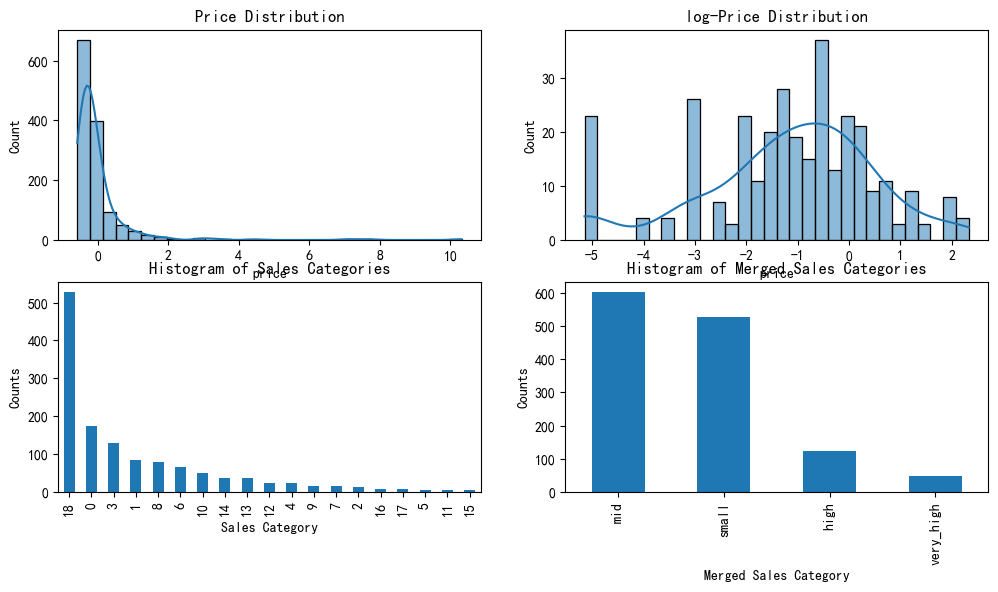

In [25]:
# 3. 描述性统计
print(f.describe())


plt.rcParams['font.sans-serif'] = ['SimHei'] # 或其他支持中文的字体
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# 4. 统计绘图
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(f['price'], bins=30, kde=True)
plt.title('Price Distribution')

plt.subplot(2, 2, 2)
sns.histplot(np.log(f['price']), bins=30, kde=True)
plt.title('log-Price Distribution')



plt.subplot(2, 2, 3)
f['sales_category'].value_counts().plot(kind='bar')
plt.xlabel('Sales Category')
plt.ylabel('Counts')
plt.title('Histogram of Sales Categories')




# 继续之后的数据处理和可视化
# 按照类名对数据进行排序
sorted_data2 = f['merged_sales_category'].value_counts().sort_index()
plt.subplot(2, 2, 4)
# 绘制排序后的直方图

f['merged_sales_category'].value_counts().plot(kind='bar')
plt.xlabel('Merged Sales Category')
plt.ylabel('Counts')
plt.title('Histogram of Merged Sales Categories')

plt.show()




In [9]:
sorted_data2

high         123
mid          603
small        528
very_high     48
Name: merged_sales_category, dtype: int64

In [6]:
def load_stopwords(path):
    with open(path, 'r', encoding='utf-8') as file:
        stopwords = set([line.strip() for line in file])
    return stopwords

stopwords = load_stopwords("stopword.txt")


# 对comment列进行分词处理
def segment(text, stopwords):
    words = jieba.cut(text)
    return [word for word in words if word not in stopwords]

# 使用分词和去除停用词
f['words'] = f['title'].apply(lambda x: segment(x, stopwords))
#f.to_csv('cleaned_file.csv')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\11385\AppData\Local\Temp\jieba.cache
Loading model cost 0.847 seconds.
Prefix dict has been built successfully.


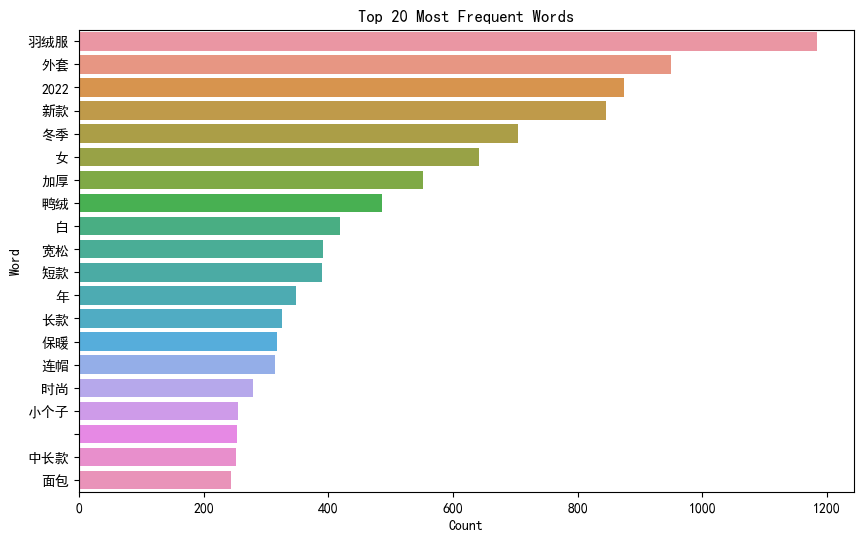

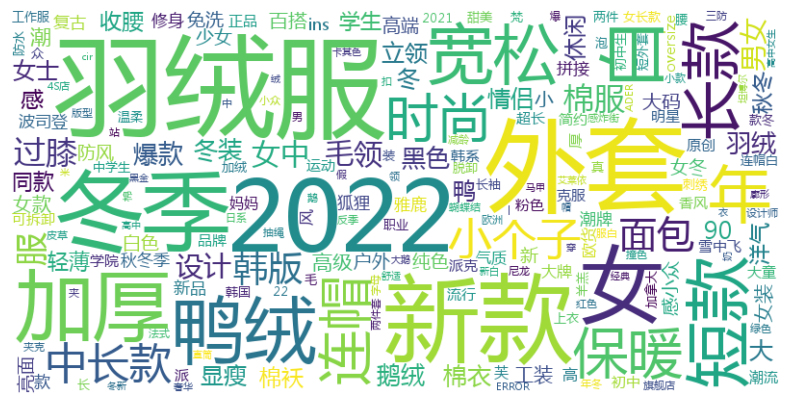

In [7]:
# 合并所有分词结果到一个长列表中
all_words = sum(f['words'], [])

# 统计词频
word_counts = Counter(all_words)

# 转换为DataFrame用于进一步分析
df_word_counts = pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)


# 指定中文字体，例如使用"SimHei"
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题
# 取前N个最常见的词
top_n = 20
top_words = df_word_counts.head(top_n)

# 绘制条形图
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=top_words)
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()
# 生成词云
font_path = '微软雅黑.ttf'  # 替换为您的字体文件路径
wordcloud = WordCloud(
    font_path=font_path,  # 指定字体路径
    width=800, 
    height=400, 
    background_color='white'
).generate_from_frequencies(word_counts)

# 显示词云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 数据中心化

In [15]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.nn.utils.rnn import pad_sequence
import torch

scaler = StandardScaler()
f['price'] = scaler.fit_transform(f[['price']])


encoder = LabelEncoder()
f['sales_category'] = encoder.fit_transform(f['sales_category'])

### 字符串处理

In [7]:
# 词向量


# 创建词汇表
vocab = set(word for title in f['words'] for word in title)
word_to_idx = {word: i+1 for i, word in enumerate(vocab)}  # 从1开始编号，预留0作为padding

# 转换为索引序列
f['title_index'] = f['words'].apply(lambda x: [word_to_idx[word] for word in x])


padded_titles = pad_sequence([torch.tensor(seq) for seq in f['title_index']], 
                             batch_first=True, padding_value=0)
titles = torch.tensor(padded_titles, dtype=torch.long)
prices = torch.tensor(f['price'].values, dtype=torch.float32)
sales = torch.tensor(f['sales_category'].values, dtype=torch.long)

# 假设titles和prices是输入特征，sales是目标
data1 = torch.utils.data.TensorDataset(titles, prices, sales)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [8]:
# word2vec
#使用gensim中的Word2Vec
from gensim.models import Word2Vec
# 训练Word2Vec模型，size为词向量的维度，词频小于min_count的词将不被考虑
sentences = f['words'].tolist()
Vec_model = Word2Vec(sentences, vector_size=256, min_count=1)
#Vec_model.save("word2vec.model")

In [9]:
def sentence_to_avg_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 将每个句子转换为平均词向量
word2vec_vectors = np.array([sentence_to_avg_vector(sentence, Vec_model) for sentence in sentences])


# 转换为torch.Tensor
titles_word2vec = torch.tensor(word2vec_vectors, dtype=torch.float32)


# 创建TensorDataset
data_word2vec = torch.utils.data.TensorDataset(titles_word2vec, prices, sales)

In [10]:
# 字符串处理



# 使用 TFIDF 处理 'title' 列
vectorizer = TfidfVectorizer(stop_words=stopwords, tokenizer=jieba.lcut)
tfidf_matrix = vectorizer.fit_transform(f['title'])


# 将 TFIDF 矩阵转换为 DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names())

# 合并原始数据集和 TFIDF DataFrame
f = pd.concat([f, tfidf_df], axis=1)

titles2 = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float32)
data2 = torch.utils.data.TensorDataset(titles2, prices, sales)

f.head()


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['##', 'lex', '~', '±', '÷', 'β', 'δ', 'λ', 'ξ', 'ψ', 'в', '…', '′', '″', 'ⅲ', '∈', '∧', '∪', '─', '☆', '下', '不', '为什', '什', '今', '使', '元', '先', '却', '只', '吨', '唷', '啪', '喔', '天', '好', '後', '数', '日', '昉', '最', '末', '漫', '然', '特', '特别', '见', '设', '说', '达', '面', '麽', '０', '１', '２', '３', '５', 'ａ', 'ｂ', 'ｃ', 'ｄ', 'ｅ', 'ｆ', 'ｇ', 'ｈ', 'ｉ', 'ｊ', 'ｌ', 'ｎ', 'ｏ', 'ｒ', 'ｔ', 'ｘ', 'ｚ', '｛', '｜'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,title,price,sales,sales_category,merged_sales_category,words,title_index,,!,02049,...,鹅绒,鹅黄色,麦檬,黄色,黑,黑标,黑色,黑金,龙虾,龟背
0,雪中飞2022秋冬新款时尚休闲小众宽松廓形中长款肌理感羽绒服爆,0.307844,1万+,2,very_high,"[雪中飞, 2022, 秋冬, 新款, 时尚, 休闲, 小, 众, 宽松, 廓形, 中长款,...","[357, 60, 456, 612, 831, 81, 220, 1056, 677, 5...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,长款过膝藏青色大毛领连帽羽绒服女2022冬装新款爆款90白鸭绒外套,-0.336917,1000+,1,high,"[长款, 过膝, 藏青色, 大, 毛领, 连帽, 羽绒服, 女, 2022, 冬装, 新款,...","[4, 244, 361, 314, 896, 82, 670, 473, 60, 558,...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,迪士尼朱迪疯狂动物城原创森女部落中长款加厚白鸭绒羽绒服可爱萌,-0.196769,300+,6,mid,"[迪士尼, 朱迪, 疯狂, 动物, 城, 原创, 森女, 部落, 中长款, 加厚, 白, 鸭...","[756, 91, 472, 1016, 343, 811, 183, 231, 653, ...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,羽绒服冬季女2022年新款白鸭绒高端奢华小众中长款外套棉袄衣棉服,-0.058232,1,18,small,"[羽绒服, 冬季, 女, 2022, 年, 新款, 白, 鸭绒, 高端, 奢华, 小众, 中...","[670, 792, 473, 60, 160, 612, 415, 772, 114, 8...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,雪中飞2022秋冬新品潮流女装可脱卸帽长款加大廓形保暖防寒羽绒服,0.207163,1万+,2,very_high,"[雪中飞, 2022, 秋冬, 新品, 潮流, 女装, 脱卸, 帽长款, 加大, 廓形, 保...","[357, 60, 456, 390, 157, 89, 852, 9, 762, 519,...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 小数据集初步探索

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score



# 分割特征和标签
X = f.drop(['title','words','sales','sales_category','merged_sales_category'], axis=1)  # 删除 'sales' 列作为特征
y = f['sales_category']  # 'sales' 列是标签

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "逻辑回归": LogisticRegression(),
    "决策树分类": DecisionTreeClassifier(random_state=42),
    "随机森林分类": RandomForestClassifier(random_state=42),
    "梯度提升分类": GradientBoostingClassifier(random_state=42),
    "支持向量分类（SVM）": SVC(),
    "极端随机树": ExtraTreesClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# 训练和评估模型
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"{name} - 准确率: {accuracy:.2f}")


逻辑回归 - 准确率: 0.35
决策树分类 - 准确率: 0.60
随机森林分类 - 准确率: 0.60
梯度提升分类 - 准确率: 0.58
支持向量分类（SVM） - 准确率: 0.35
极端随机树 - 准确率: 0.60
XGBoost - 准确率: 0.59
LightGBM - 准确率: 0.53


最高准确率：决策树分类、随机森林分类和极端随机树在这组模型中表现最好，准确率均为 0.60。这表明这些模型在你的数据集上相对更有效。

较低准确率的模型：逻辑回归和支持向量分类（SVM）的准确率为 0.35，相对较低。这可能意味着这些模型对于你的特定数据集不是很合适，或者可能需要更多的调优来提高性能。

中等准确率的模型：梯度提升分类、XGBoost 和 LightGBM 的准确率介于 0.53 至 0.59 之间，表现出中等水平的性能。

### 数据加载

In [11]:
from torch.utils.data import DataLoader, random_split
total_size = len(data2)
train_size = int(0.3 * total_size)
test_size = total_size - train_size
batch_size = 32 

# 针对三种嵌入方式
train_dataset1, test_dataset1 = random_split(data1, [train_size, test_size])
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)

train_dataset2, test_dataset2 = random_split(data2, [train_size, test_size])
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)




In [12]:
train_dataset3, test_dataset3 = random_split(data_word2vec, [train_size, test_size])
train_loader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
test_loader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=False)

**现在模型的输入是18+1维和1062+1维以及256+1维**

In [12]:
data_iter = iter(train_loader2)
sample_batched = next(data_iter)

# 打印每部分数据的形状
print("Batch shape:")
for i, tensor in enumerate(sample_batched):
    print(f"Part {i}: {tensor.size()}")

Batch shape:
Part 0: torch.Size([32, 1062])
Part 1: torch.Size([32])
Part 2: torch.Size([32])


In [13]:
data_iter = iter(train_loader1)
sample_batched = next(data_iter)

# 打印每部分数据的形状
print("Batch shape:")
for i, tensor in enumerate(sample_batched):
    print(f"Part {i}: {tensor.size()}")

Batch shape:
Part 0: torch.Size([32, 18])
Part 1: torch.Size([32])
Part 2: torch.Size([32])


In [53]:
data_iter = iter(train_loader3)
sample_batched = next(data_iter)

# 打印每部分数据的形状
print("Batch shape:")
for i, tensor in enumerate(sample_batched):
    print(f"Part {i}: {tensor.size()}")

Batch shape:
Part 0: torch.Size([32, 256])
Part 1: torch.Size([32])
Part 2: torch.Size([32])


### 几个深度学习模型

#### CNN

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CombinedCNNSalesPredictor(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CombinedCNNSalesPredictor, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # 用虚拟输入数据计算卷积层的输出维度
        dummy_input = torch.zeros(1, input_size).unsqueeze(0)
        dummy_output = self.pool(F.relu(self.conv2(self.pool(F.relu(self.conv1(dummy_input))))))
        num_features = dummy_output.numel()

        # 定义一个全连接层
        self.fc1 = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [14]:
def train(model, epochs_num, train_loader, test_loader,patience,lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)  # 确保使用正确的模型参数
    epochs = epochs_num

    # 设置早停参数
    
    best_loss = float('inf')
    trigger_times = 0
    
    trainloss,trainacc,validloss,validacc=[],[],[],[]
    for epoch in range(epochs):
        model.train()  # 设置模型到训练模式
        train_loss = 0
        train_correct = 0
        train_total = 0
        for titles, prices, labels in train_loader:
            titles, prices, labels = titles.to(device), prices.to(device), labels.long().to(device)

            # 组合titles和prices的特征
            features = torch.cat([titles, prices.unsqueeze(1)], dim=1)

            # 前向传播
            outputs = model(features)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # 计算训练正确率
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # 计算训练集平均损失和正确率
        train_loss /= len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # 验证阶段
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for titles, prices, labels in test_loader:
                titles, prices, labels = titles.to(device), prices.to(device), labels.to(device)
                features = torch.cat([titles, prices.unsqueeze(1)], dim=1)
                outputs = model(features)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # 计算验证正确率
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # 计算验证集平均损失和正确率
        val_loss /= len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        # 检查是否需要早停
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Epoch {epoch}: Early stopping!')
                break

        # 输出训练集和验证集的损失和正确率
        trainloss.append(train_loss)
        trainacc.append(train_accuracy)
        validloss.append(val_loss)
        validacc.append(val_accuracy)
        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    
    epochs = range(1, len(trainloss) + 1)

    # 创建一个新的图形
    fig, ax1 = plt.subplots()

    # 绘制损失
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, trainloss, label='Train Loss', color='tab:red', marker='o')
    ax1.plot(epochs, validloss, label='Validation Loss', color='tab:red', linestyle='dashed', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # 创建双轴
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(epochs, trainacc, label='Train Accuracy', color='tab:blue', marker='x')
    ax2.plot(epochs, validacc, label='Validation Accuracy', color='tab:blue', linestyle='dashed', marker='x')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 添加图例
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title('Training and Validation Loss and Accuracy')
    plt.show()

### 不同embedding方法的效果对比

In [15]:
# 输入向量的大小（标题向量长度+1）
input_size = 19  # 假设标题是18维，价格作为一个额外维度
num_classes =19  # 设定您的类别数量
model1 = CombinedCNNSalesPredictor(input_size, num_classes).to(device)
print(model1)

CombinedCNNSalesPredictor(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=512, out_features=19, bias=True)
)


Epoch 0: Train Loss: 69.7967, Train Accuracy: 20.00%, Validation Loss: 41.4897, Validation Accuracy: 10.86%
Epoch 1: Train Loss: 29.1579, Train Accuracy: 21.54%, Validation Loss: 21.9505, Validation Accuracy: 22.81%
Epoch 2: Train Loss: 17.6718, Train Accuracy: 28.21%, Validation Loss: 18.2472, Validation Accuracy: 21.05%
Epoch 3: Train Loss: 13.6454, Train Accuracy: 31.54%, Validation Loss: 12.3700, Validation Accuracy: 35.31%
Epoch 4: Train Loss: 8.0717, Train Accuracy: 36.92%, Validation Loss: 9.8242, Validation Accuracy: 23.14%
Epoch 5: Train Loss: 6.0027, Train Accuracy: 42.05%, Validation Loss: 8.7493, Validation Accuracy: 31.47%
Epoch 6: Train Loss: 4.5494, Train Accuracy: 46.15%, Validation Loss: 7.8990, Validation Accuracy: 37.72%
Epoch 7: Train Loss: 3.3804, Train Accuracy: 54.87%, Validation Loss: 6.4500, Validation Accuracy: 36.51%
Epoch 8: Train Loss: 2.5322, Train Accuracy: 56.67%, Validation Loss: 6.1207, Validation Accuracy: 37.06%
Epoch 9: Train Loss: 2.1042, Train Acc

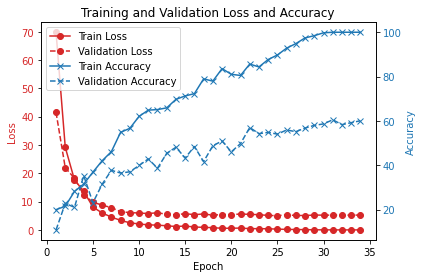

In [16]:
train(model1,100,train_loader1,test_loader1,patience=10)

In [17]:
input_size = 1062  # 假设标题是1062维，价格作为一个额外维度
model2 = CombinedCNNSalesPredictor(input_size, num_classes).to(device)
print(model2)

CombinedCNNSalesPredictor(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=33920, out_features=19, bias=True)
)


Epoch 0: Train Loss: 2.5289, Train Accuracy: 32.82%, Validation Loss: 2.3737, Validation Accuracy: 39.36%
Epoch 1: Train Loss: 2.2404, Train Accuracy: 43.33%, Validation Loss: 2.1735, Validation Accuracy: 39.36%
Epoch 2: Train Loss: 2.0966, Train Accuracy: 43.33%, Validation Loss: 2.1471, Validation Accuracy: 39.36%
Epoch 3: Train Loss: 2.0502, Train Accuracy: 43.33%, Validation Loss: 2.1618, Validation Accuracy: 39.36%
Epoch 4: Train Loss: 2.0168, Train Accuracy: 43.33%, Validation Loss: 2.0672, Validation Accuracy: 39.36%
Epoch 5: Train Loss: 1.9286, Train Accuracy: 43.33%, Validation Loss: 1.9673, Validation Accuracy: 39.36%
Epoch 6: Train Loss: 1.6781, Train Accuracy: 44.87%, Validation Loss: 1.8810, Validation Accuracy: 39.36%
Epoch 7: Train Loss: 1.3329, Train Accuracy: 49.74%, Validation Loss: 1.7130, Validation Accuracy: 45.39%
Epoch 8: Train Loss: 1.0540, Train Accuracy: 70.51%, Validation Loss: 1.6063, Validation Accuracy: 52.08%
Epoch 9: Train Loss: 0.7157, Train Accuracy: 7

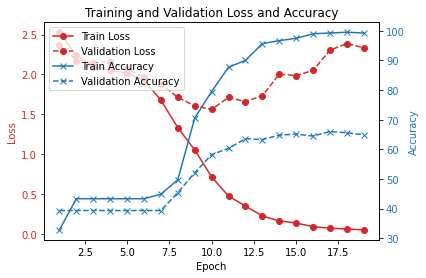

In [18]:
train(model2,100,train_loader2,test_loader2,patience=10)

Epoch 0: Train Loss: 2.2096, Train Accuracy: 37.69%, Validation Loss: 2.1988, Validation Accuracy: 39.47%
Epoch 1: Train Loss: 2.0836, Train Accuracy: 43.08%, Validation Loss: 2.1938, Validation Accuracy: 39.47%
Epoch 2: Train Loss: 2.0978, Train Accuracy: 43.08%, Validation Loss: 2.1796, Validation Accuracy: 39.47%
Epoch 3: Train Loss: 2.0447, Train Accuracy: 43.08%, Validation Loss: 2.2184, Validation Accuracy: 39.47%
Epoch 4: Train Loss: 2.0326, Train Accuracy: 43.08%, Validation Loss: 2.1535, Validation Accuracy: 39.47%
Epoch 5: Train Loss: 1.9982, Train Accuracy: 43.08%, Validation Loss: 2.1545, Validation Accuracy: 39.47%
Epoch 6: Train Loss: 2.0225, Train Accuracy: 43.08%, Validation Loss: 2.1416, Validation Accuracy: 39.47%
Epoch 7: Train Loss: 1.9843, Train Accuracy: 43.08%, Validation Loss: 2.2153, Validation Accuracy: 39.47%
Epoch 8: Train Loss: 1.9728, Train Accuracy: 43.08%, Validation Loss: 2.1625, Validation Accuracy: 39.47%
Epoch 9: Train Loss: 1.9886, Train Accuracy: 4

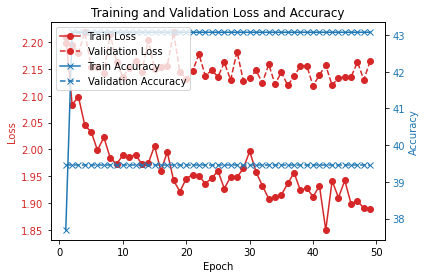

In [19]:
model3 = CombinedCNNSalesPredictor(256, num_classes).to(device)
train(model3,100,train_loader3,test_loader3,patience=10)

In [20]:
class LSTMSalesPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMSalesPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM层，假设每个标题向量是一个独立的序列
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # 全连接层，预测销售类别
        self.fc = nn.Linear(hidden_dim + 1, num_classes)

    def forward(self, features):
        # 分离titles和prices
        titles = features[:, :-1]  # 假设最后一个特征是价格
        prices = features[:, -1]

        # 调整titles的形状以适应LSTM：增加序列长度维度
        titles = titles.unsqueeze(1)  # 新形状：[batch_size, 1, input_dim]

        # LSTM层的初始隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, titles.size(0), self.hidden_dim).to(titles.device)
        c0 = torch.zeros(self.num_layers, titles.size(0), self.hidden_dim).to(titles.device)

        # 前向传播LSTM
        out, _ = self.lstm(titles, (h0, c0))

        # 选择LSTM输出的最后一个时间步
        out = out[:, -1, :]

        # 结合价格信息
        out = torch.cat([out, prices.unsqueeze(1)], dim=1)

        # 全连接层
        out = self.fc(out)
        return out


In [21]:
# 创建模型实例
input_dim = 18  # 标题向量的维度
hidden_dim = 128  # LSTM隐藏层的维度
num_layers = 2  # LSTM层数
num_classes = 19  # 您的类别数量

model4 = LSTMSalesPredictor(input_dim, hidden_dim, num_layers, num_classes).to(device)

Epoch 0: Train Loss: 2.8302, Train Accuracy: 30.51%, Validation Loss: 2.6901, Validation Accuracy: 41.01%
Epoch 1: Train Loss: 2.5133, Train Accuracy: 38.97%, Validation Loss: 2.2668, Validation Accuracy: 41.23%
Epoch 2: Train Loss: 2.1467, Train Accuracy: 38.97%, Validation Loss: 2.1438, Validation Accuracy: 41.23%
Epoch 3: Train Loss: 2.0864, Train Accuracy: 38.97%, Validation Loss: 2.1357, Validation Accuracy: 41.23%
Epoch 4: Train Loss: 2.0118, Train Accuracy: 38.97%, Validation Loss: 2.1223, Validation Accuracy: 41.23%
Epoch 5: Train Loss: 1.9852, Train Accuracy: 38.97%, Validation Loss: 2.1095, Validation Accuracy: 41.23%
Epoch 6: Train Loss: 2.0705, Train Accuracy: 38.97%, Validation Loss: 2.1106, Validation Accuracy: 41.23%
Epoch 7: Train Loss: 1.9332, Train Accuracy: 38.97%, Validation Loss: 2.1032, Validation Accuracy: 41.23%
Epoch 8: Train Loss: 1.9173, Train Accuracy: 38.97%, Validation Loss: 2.0900, Validation Accuracy: 41.23%
Epoch 9: Train Loss: 1.8482, Train Accuracy: 3

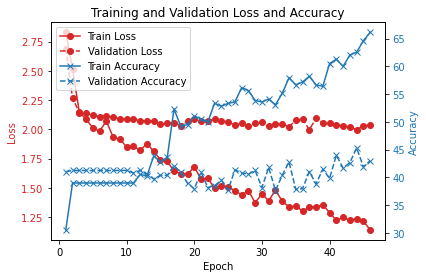

In [22]:
train(model4,100,train_loader1,test_loader1,patience=10)

Epoch 0: Train Loss: 2.9392, Train Accuracy: 2.56%, Validation Loss: 2.9109, Validation Accuracy: 30.48%
Epoch 1: Train Loss: 2.8462, Train Accuracy: 42.56%, Validation Loss: 2.7644, Validation Accuracy: 39.36%
Epoch 2: Train Loss: 2.6092, Train Accuracy: 43.33%, Validation Loss: 2.4226, Validation Accuracy: 39.36%
Epoch 3: Train Loss: 2.2415, Train Accuracy: 43.33%, Validation Loss: 2.1387, Validation Accuracy: 39.36%
Epoch 4: Train Loss: 2.0510, Train Accuracy: 43.33%, Validation Loss: 2.1170, Validation Accuracy: 39.36%
Epoch 5: Train Loss: 1.9740, Train Accuracy: 43.33%, Validation Loss: 2.0816, Validation Accuracy: 39.36%
Epoch 6: Train Loss: 1.9367, Train Accuracy: 43.33%, Validation Loss: 2.0744, Validation Accuracy: 39.36%
Epoch 7: Train Loss: 1.9084, Train Accuracy: 43.33%, Validation Loss: 2.0529, Validation Accuracy: 39.36%
Epoch 8: Train Loss: 1.8602, Train Accuracy: 43.33%, Validation Loss: 2.0275, Validation Accuracy: 39.36%
Epoch 9: Train Loss: 1.8077, Train Accuracy: 43

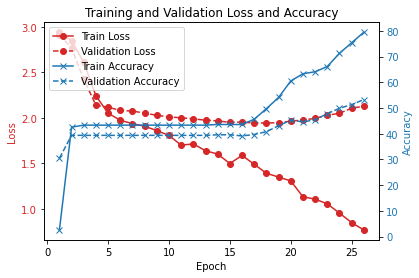

In [23]:
input_dim = 1062  # 标题向量的维度

model5 = LSTMSalesPredictor(input_dim, hidden_dim, num_layers, num_classes).to(device)
train(model5,100,train_loader2,test_loader2,patience=10)

Epoch 0: Train Loss: 2.3265, Train Accuracy: 36.67%, Validation Loss: 2.2387, Validation Accuracy: 39.47%
Epoch 1: Train Loss: 2.0266, Train Accuracy: 43.08%, Validation Loss: 2.1712, Validation Accuracy: 39.47%
Epoch 2: Train Loss: 2.0110, Train Accuracy: 43.08%, Validation Loss: 2.1577, Validation Accuracy: 39.47%
Epoch 3: Train Loss: 1.9692, Train Accuracy: 43.08%, Validation Loss: 2.1620, Validation Accuracy: 39.47%
Epoch 4: Train Loss: 1.9705, Train Accuracy: 43.08%, Validation Loss: 2.1931, Validation Accuracy: 39.47%
Epoch 5: Train Loss: 1.9547, Train Accuracy: 43.08%, Validation Loss: 2.1660, Validation Accuracy: 39.47%
Epoch 6: Train Loss: 1.9713, Train Accuracy: 43.08%, Validation Loss: 2.1653, Validation Accuracy: 39.47%
Epoch 7: Train Loss: 1.9746, Train Accuracy: 43.08%, Validation Loss: 2.1592, Validation Accuracy: 39.47%
Epoch 8: Train Loss: 1.9899, Train Accuracy: 43.08%, Validation Loss: 2.1677, Validation Accuracy: 39.47%
Epoch 9: Train Loss: 2.0128, Train Accuracy: 4

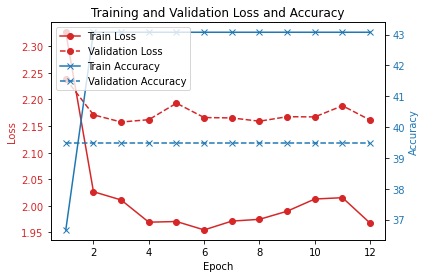

In [24]:
input_dim = 256  # 标题向量的维度

model6 = LSTMSalesPredictor(input_dim, hidden_dim, num_layers, num_classes).to(device)
train(model6,100,train_loader3,test_loader3,patience=10,lr=0.01)

## 过拟合处理
### 类别的合并
### 数据增强

In [25]:
import json

# 假设您的同义词词典文件名为'synonyms.json'
with open('synonyms_expanded_narrow.json', 'r', encoding='utf-8') as file:
    synonym_dict = json.load(file)

print(synonym_dict['冬季'])

print(synonym_dict['简约'])


['冬']
['简单']


In [26]:
import random


# 假设您的DataFrame名为df，其中包含列'title', 'prices', 'sales'以及分词后的'words'
# 筛选sales=='high'的行
high_sales_df = f.query("merged_sales_category=='high'")[['title','price','sales','sales_category','merged_sales_category','words']]
very_high_sales_df=f.query("merged_sales_category=='very_high'")[['title','price','sales','sales_category','merged_sales_category','words']]
other_df=f.query("merged_sales_category!='high'&merged_sales_category!='very_high'")[['title','price','sales','sales_category','merged_sales_category','words']]
# 准备增强数据
def augment_row(high_sales_df, n_aim, synonym_dict, replacement_ratio=0.3):
    augmented_rows = []

    while len(augmented_rows) < n_aim:
        for _, row in high_sales_df.iterrows():
            words = row['words']  # 分词结果
            new_words = words.copy()

            # 计算要替换的词汇数量
            num_replacements = int(len(words) * replacement_ratio)
            words_to_replace = random.sample(words, min(num_replacements, len(words)))

            # 对选中的词汇进行替换
            for word in words_to_replace:
                if word in synonym_dict:
                    synonym = random.choice(synonym_dict[word])
                    new_words = [synonym if w == word else w for w in new_words]

            new_title = ''.join(new_words)
            augmented_rows.append([new_title, row['price'], row['sales'], row['sales_category'], row['merged_sales_category'], row['words']])

            if len(augmented_rows) >= n_aim:
                break

    return augmented_rows



In [27]:
# 将增强的数据添加到原始DataFrame
augmented_df_high = pd.DataFrame(augment_row(high_sales_df,350,synonym_dict), columns=['title','price','sales','sales_category','merged_sales_category','words'])
augmented_df_very_high = pd.DataFrame(augment_row(very_high_sales_df,300,synonym_dict), columns=['title','price','sales','sales_category','merged_sales_category','words'])
df = pd.concat([other_df, augmented_df_high,augmented_df_very_high], ignore_index=True)
df.head()

,title,price,sales,sales_category,merged_sales_category,words
0,迪士尼朱迪疯狂动物城原创森女部落中长款加厚白鸭绒羽绒服可爱萌,-0.196769,300+,6,mid,"[迪士尼, 朱迪, 疯狂, 动物, 城, 原创, 森女, 部落, 中长款, 加厚, 白, 鸭..."
1,羽绒服冬季女2022年新款白鸭绒高端奢华小众中长款外套棉袄衣棉服,-0.058232,1,18,small,"[羽绒服, 冬季, 女, 2022, 年, 新款, 白, 鸭绒, 高端, 奢华, 小众, 中..."
2,短款羽绒服冬季女2022年新白鸭绒小众百搭宽松黑色棉袄衣棉服外套,-0.224960,7,18,small,"[短款, 羽绒服, 冬季, 女, 2022, 年, 新白, 鸭绒, 小众, 百搭, 宽松, ..."
3,艾莱依白色羽绒服女装2022新款潮流长款时尚休闲宽松设计秋冬外套,-0.167370,400+,8,mid,"[艾莱依, 白色, 羽绒服, 女装, 2022, 新款, 潮流, 长款, 时尚, 休闲, 宽..."
4,小个子羽绒棉服女冬中长款加厚保暖棉衣2022新款初中高中学生棉袄,-0.398131,63,18,small,"[小个子, 羽绒, 棉服, 女冬中, 长款, 加厚, 保暖, 棉衣, 2022, 新款, 初..."


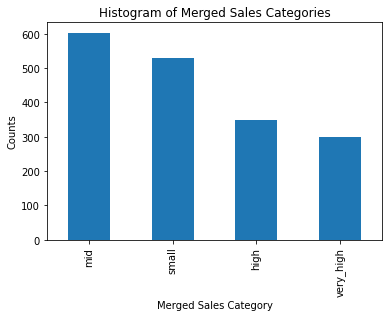

In [28]:
sorted_data3 = df['merged_sales_category'].value_counts().sort_index()

# 绘制排序后的直方图

df['merged_sales_category'].value_counts().plot(kind='bar')
plt.xlabel('Merged Sales Category')
plt.ylabel('Counts')
plt.title('Histogram of Merged Sales Categories')

plt.show()

In [29]:
# 字符串处理
encoder = LabelEncoder()
df['merged_sales_category'] = encoder.fit_transform(df['merged_sales_category'])

prices2 = torch.tensor(df['price'].values, dtype=torch.float32)
sales2 = torch.tensor(df['merged_sales_category'].values, dtype=torch.long)

# 使用 TFIDF 处理 'title' 列
vectorizer = TfidfVectorizer(stop_words=stopwords, tokenizer=jieba.lcut)
tfidf_matrix = vectorizer.fit_transform(df['title'])


# 将 TFIDF 矩阵转换为 DataFrame
tfidf_df_new = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names())

# 合并原始数据集和 TFIDF DataFrame
df = pd.concat([df, tfidf_df_new], axis=1)

titles3 = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float32)
data4 = torch.utils.data.TensorDataset(titles3, prices2, sales2)



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['##', 'lex', '~', '±', '÷', 'β', 'δ', 'λ', 'ξ', 'ψ', 'в', '…', '′', '″', 'ⅲ', '∈', '∧', '∪', '─', '☆', '下', '不', '为什', '什', '今', '使', '元', '先', '却', '只', '吨', '唷', '啪', '喔', '天', '好', '後', '数', '日', '昉', '最', '末', '漫', '然', '特', '特别', '见', '设', '说', '达', '面', '麽', '０', '１', '２', '３', '５', 'ａ', 'ｂ', 'ｃ', 'ｄ', 'ｅ', 'ｆ', 'ｇ', 'ｈ', 'ｉ', 'ｊ', 'ｌ', 'ｎ', 'ｏ', 'ｒ', 'ｔ', 'ｘ', 'ｚ', '｛', '｜'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [30]:


# 将每个句子转换为平均词向量
word2vec_vectors2 = np.array([sentence_to_avg_vector(sentence, Vec_model) for sentence in df['words'].tolist()])


# 转换为torch.Tensor
titles_word2vec2 = torch.tensor(word2vec_vectors2, dtype=torch.float32)


# 创建TensorDataset
data_word2vec2 = torch.utils.data.TensorDataset(titles_word2vec2, prices2, sales2)

In [31]:
#训练集划分
total_size2 = len(data4)
train_size2 = int(0.3 * total_size2)
test_size2 = total_size2 - train_size2


train_dataset4, test_dataset4 = random_split(data4, [train_size2, test_size2])
train_loader4 = DataLoader(train_dataset4, batch_size=batch_size, shuffle=True)
test_loader4 = DataLoader(test_dataset4, batch_size=batch_size, shuffle=False)



In [32]:

train_dataset5, test_dataset5 = random_split(data_word2vec2, [train_size2, test_size2])
train_loader5 = DataLoader(train_dataset5, batch_size=batch_size, shuffle=True)
test_loader5 = DataLoader(test_dataset5, batch_size=batch_size, shuffle=False)

In [33]:
for title,price,sales in data4:
    vec_size=len(title)
    break
vec_size

1344

CombinedCNNSalesPredictor(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=43008, out_features=4, bias=True)
)
Epoch 0: Train Loss: 1.5086, Train Accuracy: 29.59%, Validation Loss: 1.3441, Validation Accuracy: 39.78%
Epoch 1: Train Loss: 1.3467, Train Accuracy: 34.46%, Validation Loss: 1.3577, Validation Accuracy: 34.40%
Epoch 2: Train Loss: 1.3357, Train Accuracy: 37.64%, Validation Loss: 1.3057, Validation Accuracy: 37.05%
Epoch 3: Train Loss: 1.2579, Train Accuracy: 41.95%, Validation Loss: 1.2282, Validation Accuracy: 36.73%
Epoch 4: Train Loss: 1.1273, Train Accuracy: 55.43%, Validation Loss: 1.1056, Validation Accuracy: 50.92%
Epoch 5: Train Loss: 0.9101, Train Accuracy: 72.28%, Validation Loss: 0.9315, Validation Accuracy: 63.11%
Epoch 6: Train Loss: 0.6650, Train Accuracy: 7

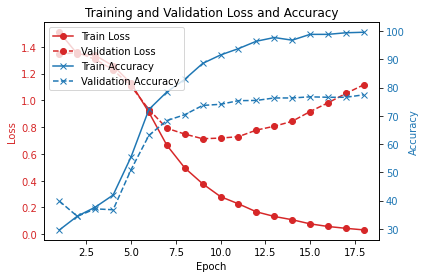

In [34]:
input_size = vec_size+1  # 假设标题是维，价格作为一个额外维度
num_classes =4  # 设定您的类别数量
model7 = CombinedCNNSalesPredictor(input_size, num_classes).to(device)
print(model7)
train(model7,100,train_loader4,test_loader4,patience=10)

CombinedCNNSalesPredictor(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=8192, out_features=4, bias=True)
)
Epoch 0: Train Loss: 1.8777, Train Accuracy: 30.52%, Validation Loss: 1.3635, Validation Accuracy: 36.33%
Epoch 1: Train Loss: 1.3519, Train Accuracy: 34.64%, Validation Loss: 1.3320, Validation Accuracy: 36.17%
Epoch 2: Train Loss: 1.3300, Train Accuracy: 36.70%, Validation Loss: 1.3153, Validation Accuracy: 36.41%
Epoch 3: Train Loss: 1.3210, Train Accuracy: 35.58%, Validation Loss: 1.3089, Validation Accuracy: 36.09%
Epoch 4: Train Loss: 1.3070, Train Accuracy: 36.89%, Validation Loss: 1.3221, Validation Accuracy: 34.72%
Epoch 5: Train Loss: 1.2942, Train Accuracy: 36.89%, Validation Loss: 1.2990, Validation Accuracy: 35.53%
Epoch 6: Train Loss: 1.2904, Train Accuracy: 37

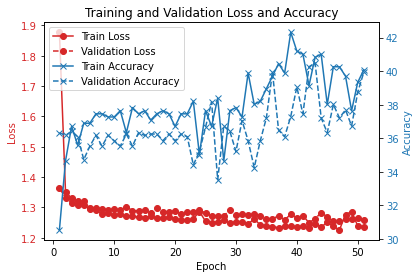

In [35]:
input_size = 256
model8 = CombinedCNNSalesPredictor(input_size, num_classes).to(device)
print(model8)
train(model8,100,train_loader5,test_loader5,patience=10,lr=0.01)

In [36]:
input_dim = vec_size # 标题向量的维度
hidden_dim = 128  # LSTM隐藏层的维度
num_layers = 2  # LSTM层数
num_classes = 4  # 您的类别数量

model9 = LSTMSalesPredictor(input_dim, hidden_dim, num_layers, num_classes).to(device)
print(model8)

CombinedCNNSalesPredictor(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=8192, out_features=4, bias=True)
)


Epoch 0: Train Loss: 1.3726, Train Accuracy: 28.65%, Validation Loss: 1.3644, Validation Accuracy: 33.20%
Epoch 1: Train Loss: 1.3478, Train Accuracy: 35.39%, Validation Loss: 1.3375, Validation Accuracy: 33.20%
Epoch 2: Train Loss: 1.3043, Train Accuracy: 35.39%, Validation Loss: 1.3023, Validation Accuracy: 33.20%
Epoch 3: Train Loss: 1.2370, Train Accuracy: 35.77%, Validation Loss: 1.2318, Validation Accuracy: 33.92%
Epoch 4: Train Loss: 1.1114, Train Accuracy: 43.26%, Validation Loss: 1.1059, Validation Accuracy: 49.80%
Epoch 5: Train Loss: 0.9152, Train Accuracy: 64.42%, Validation Loss: 0.9439, Validation Accuracy: 64.23%
Epoch 6: Train Loss: 0.6947, Train Accuracy: 79.59%, Validation Loss: 0.8005, Validation Accuracy: 68.24%
Epoch 7: Train Loss: 0.4849, Train Accuracy: 89.14%, Validation Loss: 0.6839, Validation Accuracy: 75.22%
Epoch 8: Train Loss: 0.3007, Train Accuracy: 93.26%, Validation Loss: 0.5834, Validation Accuracy: 77.47%
Epoch 9: Train Loss: 0.1754, Train Accuracy: 9

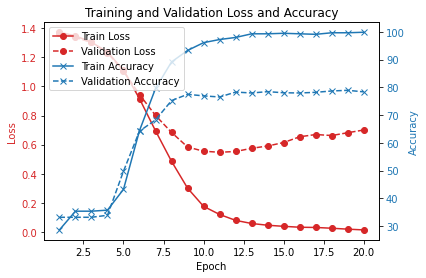

In [37]:
train(model9,100,train_loader4,test_loader4,patience=10)

Epoch 0: Train Loss: 1.3606, Train Accuracy: 35.77%, Validation Loss: 1.3481, Validation Accuracy: 34.72%
Epoch 1: Train Loss: 1.3321, Train Accuracy: 37.08%, Validation Loss: 1.3497, Validation Accuracy: 34.96%
Epoch 2: Train Loss: 1.3352, Train Accuracy: 35.96%, Validation Loss: 1.3504, Validation Accuracy: 34.32%
Epoch 3: Train Loss: 1.3343, Train Accuracy: 36.52%, Validation Loss: 1.3469, Validation Accuracy: 34.80%
Epoch 4: Train Loss: 1.3369, Train Accuracy: 37.27%, Validation Loss: 1.3461, Validation Accuracy: 36.17%
Epoch 5: Train Loss: 1.3313, Train Accuracy: 37.27%, Validation Loss: 1.3482, Validation Accuracy: 34.96%
Epoch 6: Train Loss: 1.3359, Train Accuracy: 37.27%, Validation Loss: 1.3498, Validation Accuracy: 34.96%
Epoch 7: Train Loss: 1.3328, Train Accuracy: 37.08%, Validation Loss: 1.3453, Validation Accuracy: 36.49%
Epoch 8: Train Loss: 1.3361, Train Accuracy: 37.45%, Validation Loss: 1.3471, Validation Accuracy: 35.85%
Epoch 9: Train Loss: 1.3333, Train Accuracy: 3

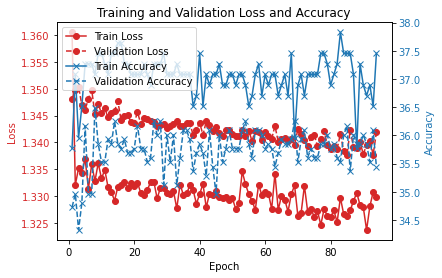

In [56]:
model10 = LSTMSalesPredictor(256, hidden_dim, num_layers, num_classes).to(device)
train(model10,100,train_loader5,test_loader5,patience=10)

In [39]:

class CombinedCNNSalesPredictor(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.5):
        super(CombinedCNNSalesPredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)  # 批量归一化层
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)  # 批量归一化层
        # 其他卷积层和BN层可以根据需要添加
        
        # 用虚拟输入数据计算卷积层的输出维度
        dummy_input = torch.zeros(1, input_size).unsqueeze(0)
        dummy_output = self.pool(F.relu(self.conv2(self.pool(F.relu(self.conv1(dummy_input))))))
        num_features = dummy_output.numel()


        # 定义一个全连接层，用于将卷积层的输出映射到类别输出
        self.fc1 = nn.Linear(num_features, num_classes)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout层

    def forward(self, x):
        x = x.unsqueeze(1)  # 增加一个维度来表示通道
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # 在全连接层之前应用Dropout
        x = self.fc1(x)
        return x


CombinedCNNSalesPredictor(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=43008, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch 0: Train Loss: 2.0407, Train Accuracy: 48.13%, Validation Loss: 1.3636, Validation Accuracy: 20.13%
Epoch 1: Train Loss: 0.4665, Train Accuracy: 82.02%, Validation Loss: 1.2691, Validation Accuracy: 31.36%
Epoch 2: Train Loss: 0.2651, Train Accuracy: 91.20%, Validation Loss: 0.9367, Validation Accuracy: 53.97%
Epoch 3: Train Loss: 0.1657, Train Accuracy: 93.82%, Validation Loss: 0.9751, Validation Accuracy: 67.12%
Epoch 4: Train Loss: 0.2002, Train A

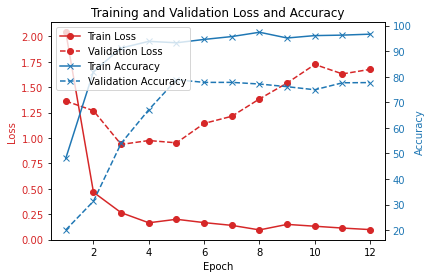

In [40]:
input_size = vec_size+1 # 假设标题是1062维，价格作为一个额外维度
model11 = CombinedCNNSalesPredictor(input_size, num_classes).to(device)
print(model11)
train(model11,100,train_loader4,test_loader4,patience=10)

Epoch 0: Train Loss: 3.1476, Train Accuracy: 28.84%, Validation Loss: 1.6161, Validation Accuracy: 29.91%
Epoch 1: Train Loss: 1.7444, Train Accuracy: 31.46%, Validation Loss: 1.5732, Validation Accuracy: 29.91%
Epoch 2: Train Loss: 1.6141, Train Accuracy: 31.09%, Validation Loss: 1.6233, Validation Accuracy: 21.57%
Epoch 3: Train Loss: 1.6494, Train Accuracy: 30.52%, Validation Loss: 1.6215, Validation Accuracy: 37.77%
Epoch 4: Train Loss: 1.7698, Train Accuracy: 26.59%, Validation Loss: 1.4318, Validation Accuracy: 37.21%
Epoch 5: Train Loss: 1.5731, Train Accuracy: 31.27%, Validation Loss: 1.4403, Validation Accuracy: 28.87%
Epoch 6: Train Loss: 1.5274, Train Accuracy: 33.90%, Validation Loss: 1.5105, Validation Accuracy: 26.62%
Epoch 7: Train Loss: 1.6862, Train Accuracy: 29.96%, Validation Loss: 1.3983, Validation Accuracy: 36.17%
Epoch 8: Train Loss: 1.5034, Train Accuracy: 35.77%, Validation Loss: 1.5093, Validation Accuracy: 25.50%
Epoch 9: Train Loss: 1.6681, Train Accuracy: 3

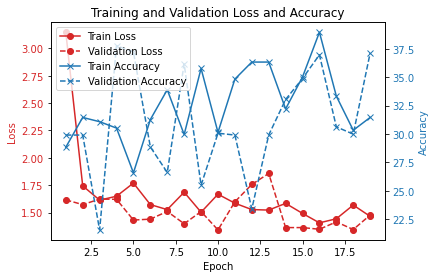

In [41]:
model12 = CombinedCNNSalesPredictor(256, num_classes).to(device)
train(model12,100,train_loader5,test_loader5,patience=10)

In [42]:
class TransformerSalesPredictor(nn.Module):
    def __init__(self, title_dim, price_dim, num_classes, num_heads, num_layers, dropout=0.1):
        super(TransformerSalesPredictor, self).__init__()

        # Transformer的配置参数
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

        # Transformer编码器层
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=title_dim, 
            nhead=num_heads, 
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer, 
            num_layers=num_layers
        )

        # 为了将价格信息融合进模型，增加一个额外的全连接层
        self.fc_price = nn.Linear(price_dim, title_dim)  # 将价格维度映射到与标题相同的维度

        # 最后的分类器
        self.classifier = nn.Linear(title_dim, num_classes)

    def forward(self, features):
        # 假设最后一个特征是价格
        titles = features[:, :-1]
        prices = features[:, -1]

        # 调整titles的形状以适应Transformer：增加序列长度维度
        titles = titles.unsqueeze(1)

        # 通过Transformer编码器
        transformer_out = self.transformer_encoder(titles)

        # 选择Transformer输出的最后一个时间步
        transformer_out = transformer_out[:, -1, :]

        # 映射价格到标题相同的维度
        transformed_price = F.relu(self.fc_price(prices.unsqueeze(1)))

        # 结合标题和价格信息
        combined = transformer_out + transformed_price

        # 分类器
        output = self.classifier(combined)
        return output

In [45]:
# 创建模型实例
title_dim= vec_size  # 标题向量的维度
price_dim=1
num_classes = 4  # 您的类别数量
num_heads =4  # Transformer头的数量
num_layers =2   # Transformer编码器层数


Epoch 0: Train Loss: 3.9986, Train Accuracy: 28.84%, Validation Loss: 1.7471, Validation Accuracy: 30.07%
Epoch 1: Train Loss: 1.5342, Train Accuracy: 30.71%, Validation Loss: 1.3580, Validation Accuracy: 35.61%
Epoch 2: Train Loss: 1.3637, Train Accuracy: 34.27%, Validation Loss: 1.3282, Validation Accuracy: 36.33%
Epoch 3: Train Loss: 1.3582, Train Accuracy: 32.96%, Validation Loss: 1.3173, Validation Accuracy: 36.33%
Epoch 4: Train Loss: 1.3705, Train Accuracy: 35.02%, Validation Loss: 1.4600, Validation Accuracy: 22.69%
Epoch 5: Train Loss: 1.3940, Train Accuracy: 29.59%, Validation Loss: 1.4081, Validation Accuracy: 34.40%
Epoch 6: Train Loss: 1.3689, Train Accuracy: 33.90%, Validation Loss: 1.3455, Validation Accuracy: 33.44%
Epoch 7: Train Loss: 1.3300, Train Accuracy: 35.77%, Validation Loss: 1.3025, Validation Accuracy: 37.05%
Epoch 8: Train Loss: 1.3611, Train Accuracy: 32.21%, Validation Loss: 1.4221, Validation Accuracy: 35.85%
Epoch 9: Train Loss: 1.3704, Train Accuracy: 3

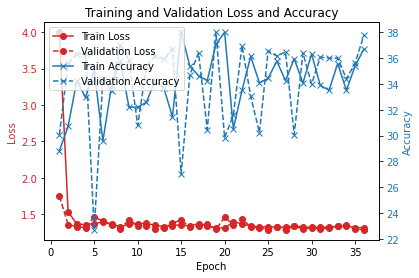

In [46]:
model13 = TransformerSalesPredictor(title_dim,price_dim, num_classes, num_heads, num_layers).to(device)
train(model=model13, epochs_num=100, train_loader=train_loader4, test_loader=test_loader4,patience=10)

Epoch 0: Train Loss: nan, Train Accuracy: 20.60%, Validation Loss: nan, Validation Accuracy: 19.73%
Epoch 1: Train Loss: nan, Train Accuracy: 19.48%, Validation Loss: nan, Validation Accuracy: 19.73%
Epoch 2: Train Loss: nan, Train Accuracy: 19.48%, Validation Loss: nan, Validation Accuracy: 19.73%
Epoch 3: Train Loss: nan, Train Accuracy: 19.48%, Validation Loss: nan, Validation Accuracy: 19.73%
Epoch 4: Train Loss: nan, Train Accuracy: 19.48%, Validation Loss: nan, Validation Accuracy: 19.73%
Epoch 5: Train Loss: nan, Train Accuracy: 19.48%, Validation Loss: nan, Validation Accuracy: 19.73%
Epoch 6: Train Loss: nan, Train Accuracy: 19.48%, Validation Loss: nan, Validation Accuracy: 19.73%
Epoch 7: Train Loss: nan, Train Accuracy: 19.48%, Validation Loss: nan, Validation Accuracy: 19.73%
Epoch 8: Train Loss: nan, Train Accuracy: 19.48%, Validation Loss: nan, Validation Accuracy: 19.73%
Epoch 9: Early stopping!


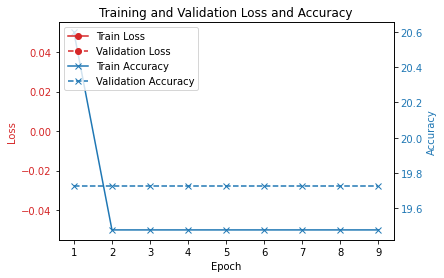

In [52]:
model14 = TransformerSalesPredictor(256,price_dim, num_classes, 4, num_layers).to(device)
train(model=model14, epochs_num=100, train_loader=train_loader5, test_loader=test_loader5,patience=10,lr=5*10e3)

In [53]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)
        return out

class CombinedCNNSalesPredictorResNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CombinedCNNSalesPredictorResNet, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.resblock1 = ResidualBlock(64, 64)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.resblock2 = ResidualBlock(128, 128)

        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)  # 适应性池化层

        self.fc1 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # 增加通道维度
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.resblock2(x)

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

CombinedCNNSalesPredictorResNet(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock2): ResidualBlock(
    (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): B

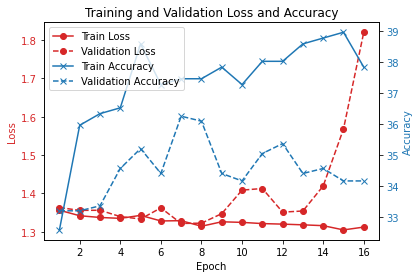

In [55]:
input_size = 1344
num_classes =4  # 设定您的类别数量
model15 = CombinedCNNSalesPredictorResNet(input_size, num_classes).to(device)
print(model15)
train(model15,100,train_loader4,test_loader4,patience=10)

In [2]:
class TextAndPriceModel(nn.Module):
    def __init__(self, word_vec_size, num_classes, max_sentence_length, price_input_size):
        super(TextAndPriceModel, self).__init__()

        # Transformer层用于处理文本数据
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=word_vec_size,
            nhead=8,
            dim_feedforward=512,
            dropout=0.1
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=3)

        # 用于处理价格的全连接层
        self.price_fc = nn.Linear(price_input_size, word_vec_size)

        # 分类器
        self.classifier = nn.Linear(word_vec_size, num_classes)
        self.flatten_size = word_vec_size * max_sentence_length
        self.fc_flatten = nn.Linear(self.flatten_size, word_vec_size)

        # 最大句子长度
        self.max_sentence_length = max_sentence_length

    def forward(self, text_data, price_data):
        # 处理文本数据
        # 调整文本数据维度以符合Transformer输入要求
        text_data = text_data.permute(1, 0, 2)  # [seq_len, batch, features]
        transformer_out = self.transformer_encoder(text_data)
        text_features = transformer_out.mean(dim=0)  # 对序列的特征取平均
        
        batch_size = text_data.size(1)
        flattened = transformer_out.permute(1, 0, 2).contiguous().view(batch_size, -1)  # [batch, seq_len * features]

        # 通过全连接层
        text_features = self.fc_flatten(flattened)

        # 处理价格数据
        
        price_data = price_data.unsqueeze(1)

        price_features = F.relu(self.price_fc(price_data))

        # 结合文本和价格特征
        combined_features = text_features + price_features

        # 分类
        # 在全连接层之前打印数据形状
        output = self.classifier(combined_features)
        return output


In [5]:
word_vec_size = 256
num_classes = 4  # 假设'sales'列包含所有类别
price_input_size = 1  # 如果'prices'是单维度的数值

model_improved = TextAndPriceModel(word_vec_size, num_classes, 18, price_input_size)


In [7]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('transformer_model')
# 创建一个示例输入（取决于您的模型输入）
example_text_data = torch.rand(1, max_sentence_length, word_vec_size)  # 文本数据
example_price_data = torch.rand(1, 1) # 价格数据

# 添加模型到TensorBoard
writer.add_graph(model_improved, [example_text_data, example_price_data])

# 关闭writer
writer.close()


ModuleNotFoundError: No module named 'tensorboard'